# Computational Social Science Project #2 

**Enter your Name:**Taylor Galdi

*Semester:* Fall 2024


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [1]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [2]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv("Project 2 Materials/Diabetes with Population Info by County 2017.csv", 
                       dtype={"CountyFIPS": str}) 

In [3]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 
#Wow, lots of features!

shape:  (3220, 95)


In [4]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)
#Hmm okay so I see some floats and integers, along with objects. I'm assuming that some of these will need to be converted

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [5]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Diabetes_Number"].str.isnumeric()]["Diabetes_Number"].unique()) 

['Suppressed']


In [6]:
#
# Now do the same as above, but for "Obesity_Number"
#-----------
print(diabetes[~diabetes["Obesity_Number"].str.isnumeric()]["Obesity_Number"].unique()) 
#Why/how is 'Suppressed' different than 'No Data'?


['No Data']


In [7]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------

print(diabetes[~diabetes["Physical_Inactivity_Number"].str.isnumeric()]["Physical_Inactivity_Number"].unique())

['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [8]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes["Diabetes_Number"] = diabetes["Diabetes_Number"].astype(int)

# Obesity
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"] 
diabetes["Obesity_Number"] = diabetes["Obesity_Number"].astype(int)


# Physical Inactivity
diabetes = diabetes[diabetes["Physical_Inactivity_Number"]!="No Data"] 
diabetes["Physical_Inactivity_Number"] = diabetes["Physical_Inactivity_Number"].astype(int)


# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float
                                                                                                                                                                                                )

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [9]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [10]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

count           mean  \
Diabetes_Number                                     3112.0       0.092857   
Obesity_Number                                      3112.0       0.251666   
Physical_Inactivity_Number                          3112.0       0.200861   
sex and age_total population_65 years and over_...  3112.0      84.275643   
race_total population                               3112.0  103682.624036   
race_total population_one race                      3112.0       0.976059   
race_total population_two or more races             3112.0       0.023941   
race_total population_one race_1                    3112.0       0.976059   
race_total population_one race_white                3112.0       0.831107   
race_total population_one race_black or african...  3112.0       0.090215   
race_total population_one race_american indian ...  3112.0       0.019398   
race_total population_one race_american indian ...  3112.0       0.001791   
race_total population_one race_american indian ...  3112.0       0.001338   
race_total population_one race_american indian ...  3112.0       0.001229   
race_total population_one race_american indian ...  3112.0       0.003315   
race_total population_one race_asian                3112.0       0.013749   
race_total population_one race_asian_asian indian   3112.0       0.002628   
race_total population_one race_asian_chinese        3112.0       0.002644   
race_total population_one race_asian_filipino       3112.0       0.002744   
race_total population_one race_asian_japanese       3112.0       0.000707   
race_total population_one race_asian_korean         3112.0       0.001174   
race_total population_one race_asian_vietnamese     3112.0       0.001255   
race_total population_one race_asian_other asian    3112.0       0.002598   
race_total population_one race_native hawaiian ...  3112.0       0.000874   
race_total population_one race_native hawaiian ...  3112.0       0.000303   
race_total population_one race_native hawaiian ...  3112.0       0.000142   
race_total population_one race_native hawaiian ...  3112.0       0.000134   
race_total population_one race_native hawaiian ...  3112.0       0.000295   
race_total population_one race_some other race      3112.0       0.020716   
race_total population_two or more races_1           3112.0       0.023941   
race_total population_two or more races_white a...  3112.0       0.006444   
race_total population_two or more races_white a...  3112.0       0.008618   
race_total population_two or more races_white a...  3112.0       0.003021   
race_total population_two or more races_black o...  3112.0       0.000652   
race alone or in combination with one or more o...  3112.0       1.000000   
race alone or in combination with one or more o...  3112.0       0.852907   
race alone or in combination with one or more o...  3112.0       0.098875   
race alone or in combination with one or more o...  3112.0       0.029923   
race alone or in combination with one or more o...  3112.0       0.018213   
race alone or in combination with one or more o...  3112.0       0.002067   
race alone or in combination with one or more o...  3112.0       0.023626   
hispanic or latino and race_total population        3112.0       1.000000   
hispanic or latino and race_total population_hi...  3112.0       0.093201   
hispanic or latino and race_total population_hi...  3112.0       0.069331   
hispanic or latino and race_total population_hi...  3112.0       0.005656   
hispanic or latino and race_total population_hi...  3112.0       0.001568   
hispanic or latino and race_total population_hi...  3112.0       0.016645   
hispanic or latino and race_total population_no...  3112.0       0.906799   
hispanic or latino and race_total population_no...  3112.0       0.765065   
hispanic or latino and race_total population_no...  3112.0       0.088817   
hispanic or latino and race_total population_no...  3112.0       0.018016   
hispanic or latino and race_total population_no..

#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [11]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['race_total population_two or more races_1',
 'race_total population_one race_1',
 'sex and age_total population_65 years and over_1',
 'sex and age_total population',
 'hispanic or latino and race_total population',
 'sex and age_total population_18 years and over_1']

In [12]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=['sex and age_total population_65 years and over_1',
 'sex and age_total population',
 'sex and age_total population_18 years and over_1',
 'race_total population_one race_1',
 'race_total population_two or more races_1',
 'hispanic or latino and race_total population'])

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [13]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes

#Save as its own dataframe for later
diabetes_counties=diabetes

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

[Text(0.5, 1.0, 'Relationship between Physical Inactivity and Diabetes ')]

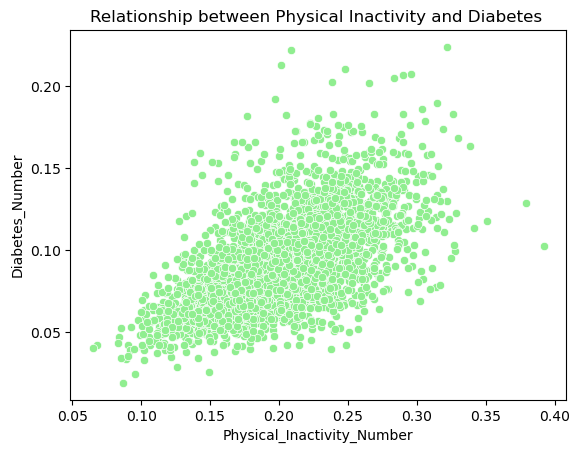

In [14]:
#
# EDA #1 and interpretations in this section 
# This scatterplot looks at the relationship between Physical Inactivity and Diabetes Rates. 
sns.scatterplot(x = "Physical_Inactivity_Number", 
            y = "Diabetes_Number", 
            data = diabetes, 
            color = "lightgreen").set(title='Relationship between Physical Inactivity and Diabetes ')
#Remember this is *inactivity* so, as we may expect, there seems to be a strong, positive association between our feature and outcome. I am assuming that 'Diabetes Number' is a reflection of the population with Diabetes. Moreover, it does not seem like we are differentiating between Type 1 and Type 2 diabetes, which feels important to note.

[Text(0.5, 1.0, 'Regional Variation in Diabetes Rates')]

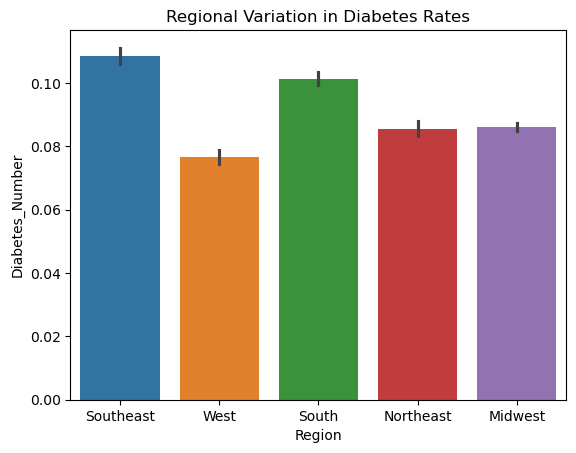

In [15]:
#
# EDA #2 and interpretations in this section 
# This barplot looks at the relationship between Regions of the United States and Diabetes Rates. 
sns.barplot(x = "Region",            
            y = "Diabetes_Number", 
            data = diabetes, 
            hue="Region", legend=False).set(title='Regional Variation in Diabetes Rates')
#We see that the Southeast and South have higher proportions of people with diabetes. We might wonder what leads to this variation, especially because we see that 'Diabetes Number' is lower in the 'West.' 
#Could we imagine that this is linked to either different rates of physical activity, access to resources (i.e. public transportation, doctors, food deserts, etc.), or infrastructure?   

[Text(0.5, 1.0, 'Regional Variation in Physical Inactivity')]

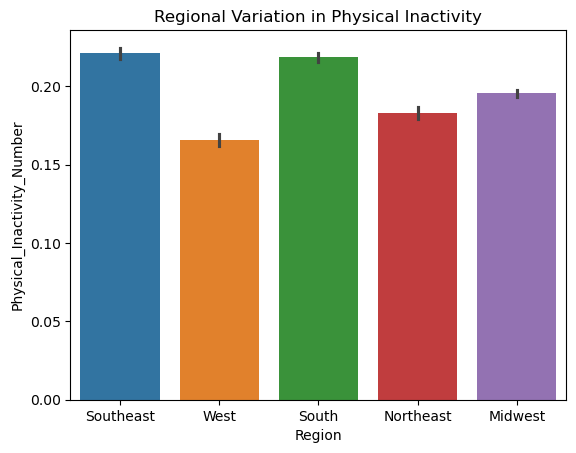

In [16]:
#EDA 3  and interpretations in this section
#Since it seems like there's a relationship between geography and Diabetes_Number, let's try and unpack what's happening (to the extent that we can with this data. 
#This barplot looks at physical inactivity rates in different regions of the United States
sns.barplot(x = "Region",            
            y = "Physical_Inactivity_Number", 
            data = diabetes, 
            hue="Region", legend=False).set(title='Regional Variation in Physical Inactivity')
#Okay, it seems like there are regional differences in physical inactivity in ways that make sense given our regional differences in Diabetes_Number.

[Text(0.5, 1.0, 'Relationship between Obesity and Diabetes Rates')]

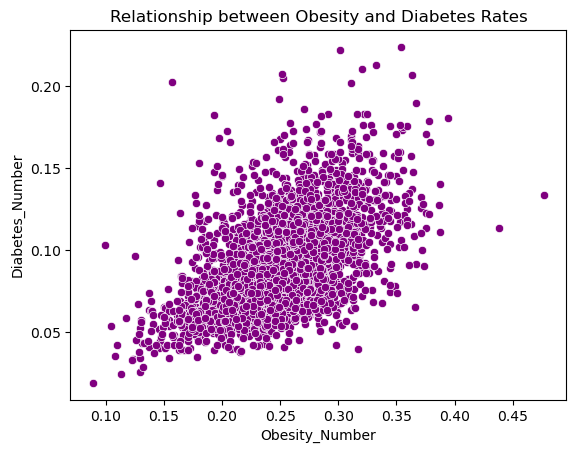

In [17]:
# EDA #5 and interpretations in this section
# This scatterplot looks at the relationship between Obesity and Diabetes Rates
sns.scatterplot(x = "Obesity_Number", 
            y = "Diabetes_Number", 
            data = diabetes, 
            color = "purple").set(title='Relationship between Obesity and Diabetes Rates')
#Again, not super surprising that obesity would be related to diabetes, except once again, we don't seem to be distinguishing between Type 1 and Type 2, so there might not be as strong of a causal story here as we might first think...

<Figure size 640x480 with 0 Axes>

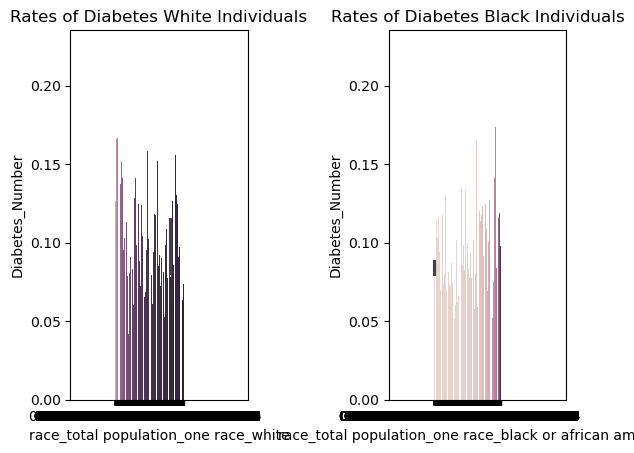

In [18]:
# EDA #5 and interpretations in this section
# This barplot looks at the relationship between Race and Diabetes. It does so in a crude way (Black vs. White people).
import matplotlib.pyplot as plt
fig = plt.figure()

# set the figure parameters
figure = plt.figure()                            # set the figure space
figure.subplots_adjust(wspace = .8, hspace=.5)   # adjust the space in between figures 

# plot 1
# ----------
figure.add_subplot(1,   # sets the number of rows
                   2,   # sets columns,
                   1)   # specifies the following code is for the first plot  

# specify barplot for White individuals
sns.barplot(x="race_total population_one race_white", 
            y="Diabetes_Number", 
            data=diabetes,
           hue="race_total population_one race_white", legend=False).set_title("Rates of Diabetes White Individuals")

# ensure the x-axis is the same on both plots
plt.xlim(-2000,6000)


# plot 2
# ----------
figure.add_subplot(1,   # sets the number of rows
                   2,   # sets columns,
                   2)   # specifies the following code is for the second plot

# specify barplot for Black individuals
sns.barplot(x="race_total population_one race_black or african american", 
            y="Diabetes_Number", 
            data=diabetes,
           hue="race_total population_one race_black or african american", legend=False).set_title("Rates of Diabetes Black Individuals")

# ensure the x-axis is the same on both plots
plt.xlim(-2000,6000)

# show the plots
plt.show()
#This is both interesting and unhelpful at the same time. We can see variance both by race and by county, but there are too many counties to make super meaningful conections.

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [19]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ["Region"],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ["County", "State"],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?
                                        #Axis 1!

# look at first 10 rows of new data frame 
diabetes_clean.head(10)

CountyFIPS  Diabetes_Number  Obesity_Number  Physical_Inactivity_Number  \
0      01001         0.093804        0.244366                    0.226902   
1      01003         0.080281        0.233255                    0.192324   
2      01005         0.131875        0.310643                    0.210651   
3      01007         0.105251        0.290052                    0.258667   
4      01009         0.108977        0.246804                    0.249198   
5      01011         0.224208        0.353748                    0.321967   
6      01013         0.145318        0.349513                    0.300974   
7      01015         0.127648        0.298580                    0.234140   
8      01017         0.141518        0.324425                    0.220570   
9      01019         0.122848        0.300429                    0.237342   

   sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
0                                               76.5                                  
1                                               86.6                                  
2                                               76.2                                  
3                                               80.5                                  
4                                               79.7                                  
5                                               73.6                                  
6                                               69.1                                  
7                                               73.7                                  
8                                               73.3                                  
9                                               86.7                                  

   race_total population  race_total population_one race  \
0                  55200                        0.981341   
1                 208107                        0.982836   
2                  25782                        0.986308   
3                  22527                        0.991699   
4                  57645                        0.983780   
5                  10352                        1.000000   
6                  20025                        0.983870   
7                 115098                        0.976229   
8                  33826                        0.989742   
9                  25853                        0.991955   

   race_total population_two or more races  \
0                                 0.018659   
1                                 0.017164   
2                                 0.013692   
3                                 0.008301   
4                                 0.016220   
5                                 0.000000   
6                                 0.016130   
7                                 0.023771   
8                                 0.010258   
9                                 0.008045   

   race_total population_one race_white  \
0                              0.768786   
1                              0.862662   
2                              0.473819   
3                              0.766547   
4                              0.955052   
5                              0.219861   
6                              0.520050   
7                              0.743349   
8                              0.575977   
9                              0.928209   

   race_total population_one race_black or african american  \
0                                           0.191395          
1                                           0.094970          
2                                           0.475758          
3                                           0.222755          
4                                           0.014954          
5                                           0.762461          
6                                           0.452185          
7                                           0.2057

In [20]:
#I see that the first 10 are from the Southeast, I want to check that our recoding worked for our whole sample 
# look at first 10 rows of new data frame 
diabetes_clean.tail(10)
#Great, I see the last ten are from the West!

CountyFIPS  Diabetes_Number  Obesity_Number  Physical_Inactivity_Number  \
3210      56027         0.064951        0.218137                    0.222222   
3211      56029         0.068336        0.205625                    0.187219   
3212      56031         0.115646        0.223683                    0.172028   
3213      56033         0.066140        0.220645                    0.173764   
3214      56035         0.076877        0.215657                    0.150437   
3215      56037         0.058028        0.212208                    0.170410   
3216      56039         0.019038        0.088946                    0.086951   
3217      56041         0.069872        0.238973                    0.170751   
3218      56043         0.078361        0.213802                    0.210112   
3219      56045         0.084648        0.283803                    0.194789   

      sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
3210                                              104.4                                  
3211                                               90.9                                  
3212                                               93.8                                  
3213                                               91.3                                  
3214                                              111.2                                  
3215                                               92.0                                  
3216                                               94.8                                  
3217                                               97.6                                  
3218                                               89.0                                  
3219                                               90.6                                  

      race_total population  race_total population_one race  \
3210                   2448                        0.993464   
3211                  29121                        0.977027   
3212                   8673                        0.970483   
3213                  30012                        0.981241   
3214                   9951                        0.968043   
3215                  44117                        0.979804   
3216                  23059                        0.992020   
3217                  20609                        0.965161   
3218                   8129                        0.958420   
3219                   7100                        0.979718   

      race_total population_two or more races  \
3210                                 0.006536   
3211                                 0.022973   
3212                                 0.029517   
3213                                 0.018759   
3214                                 0.031957   
3215                                 0.020196   
3216                                 0.007980   
3217                                 0.034839   
3218                                 0.041580   
3219                                 0.020282   

      race_total population_one race_white  \
3210                              0.930556   
3211                              0.943821   
3212                              0.948115   
3213                              0.950753   
3214                              0.962516   
3215                              0.931251   
3216                              0.903422   
3217                              0.934155   
3218                              0.897158   
3219                              0.925352   

      race_total population_one race_black or african american  \
3210                                           0.005310          
3211                                           0.001614          
3212                                           0.000115          
3213                                           0.005098          
3214                                           0.000000       

In [21]:
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                         float64
Obesity_Number                                                                                                                                          float64
Physical_Inactivity_Number                                                                                                                              float64
sex and age_total population

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [22]:
#
# Partition data
#-----------

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean["Diabetes_Number"]

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(["Diabetes_Number","race alone or in combination with one or more other races_total population" ], 
                axis = 1) # refers to columns
X.head()

CountyFIPS  Obesity_Number  Physical_Inactivity_Number  \
0      01001        0.244366                    0.226902   
1      01003        0.233255                    0.192324   
2      01005        0.310643                    0.210651   
3      01007        0.290052                    0.258667   
4      01009        0.246804                    0.249198   

   sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
0                                               76.5                                  
1                                               86.6                                  
2                                               76.2                                  
3                                               80.5                                  
4                                               79.7                                  

   race_total population  race_total population_one race  \
0                  55200                        0.981341   
1                 208107                        0.982836   
2                  25782                        0.986308   
3                  22527                        0.991699   
4                  57645                        0.983780   

   race_total population_two or more races  \
0                                 0.018659   
1                                 0.017164   
2                                 0.013692   
3                                 0.008301   
4                                 0.016220   

   race_total population_one race_white  \
0                              0.768786   
1                              0.862662   
2                              0.473819   
3                              0.766547   
4                              0.955052   

   race_total population_one race_black or african american  \
0                                           0.191395          
1                                           0.094970          
2                                           0.475758          
3                                           0.222755          
4                                           0.014954          

   race_total population_one race_american indian and alaska native  \
0                                           0.002880                  
1                                           0.007314                  
2                                           0.002793                  
3                                           0.000355                  
4                                           0.002446                  

   race_total population_one race_american indian and alaska native_cherokee tribal grouping  \
0                                           0.001486                                           
1                                           0.001369                                           
2                                           0.001008                                           
3                                           0.000000                                           
4                                           0.000347                                           

   race_total population_one race_american indian and alaska native_chippewa tribal grouping  \
0                                                0.0                                           
1                                                0.0                                           
2                                                0.0                                           
3                                                0.0                                           
4                                                0.0                                           

   race_total population_one race_american indian and alaska native_navajo tribal grouping  \
0                                           0.000797                                         
1                                           0.000336                     

Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

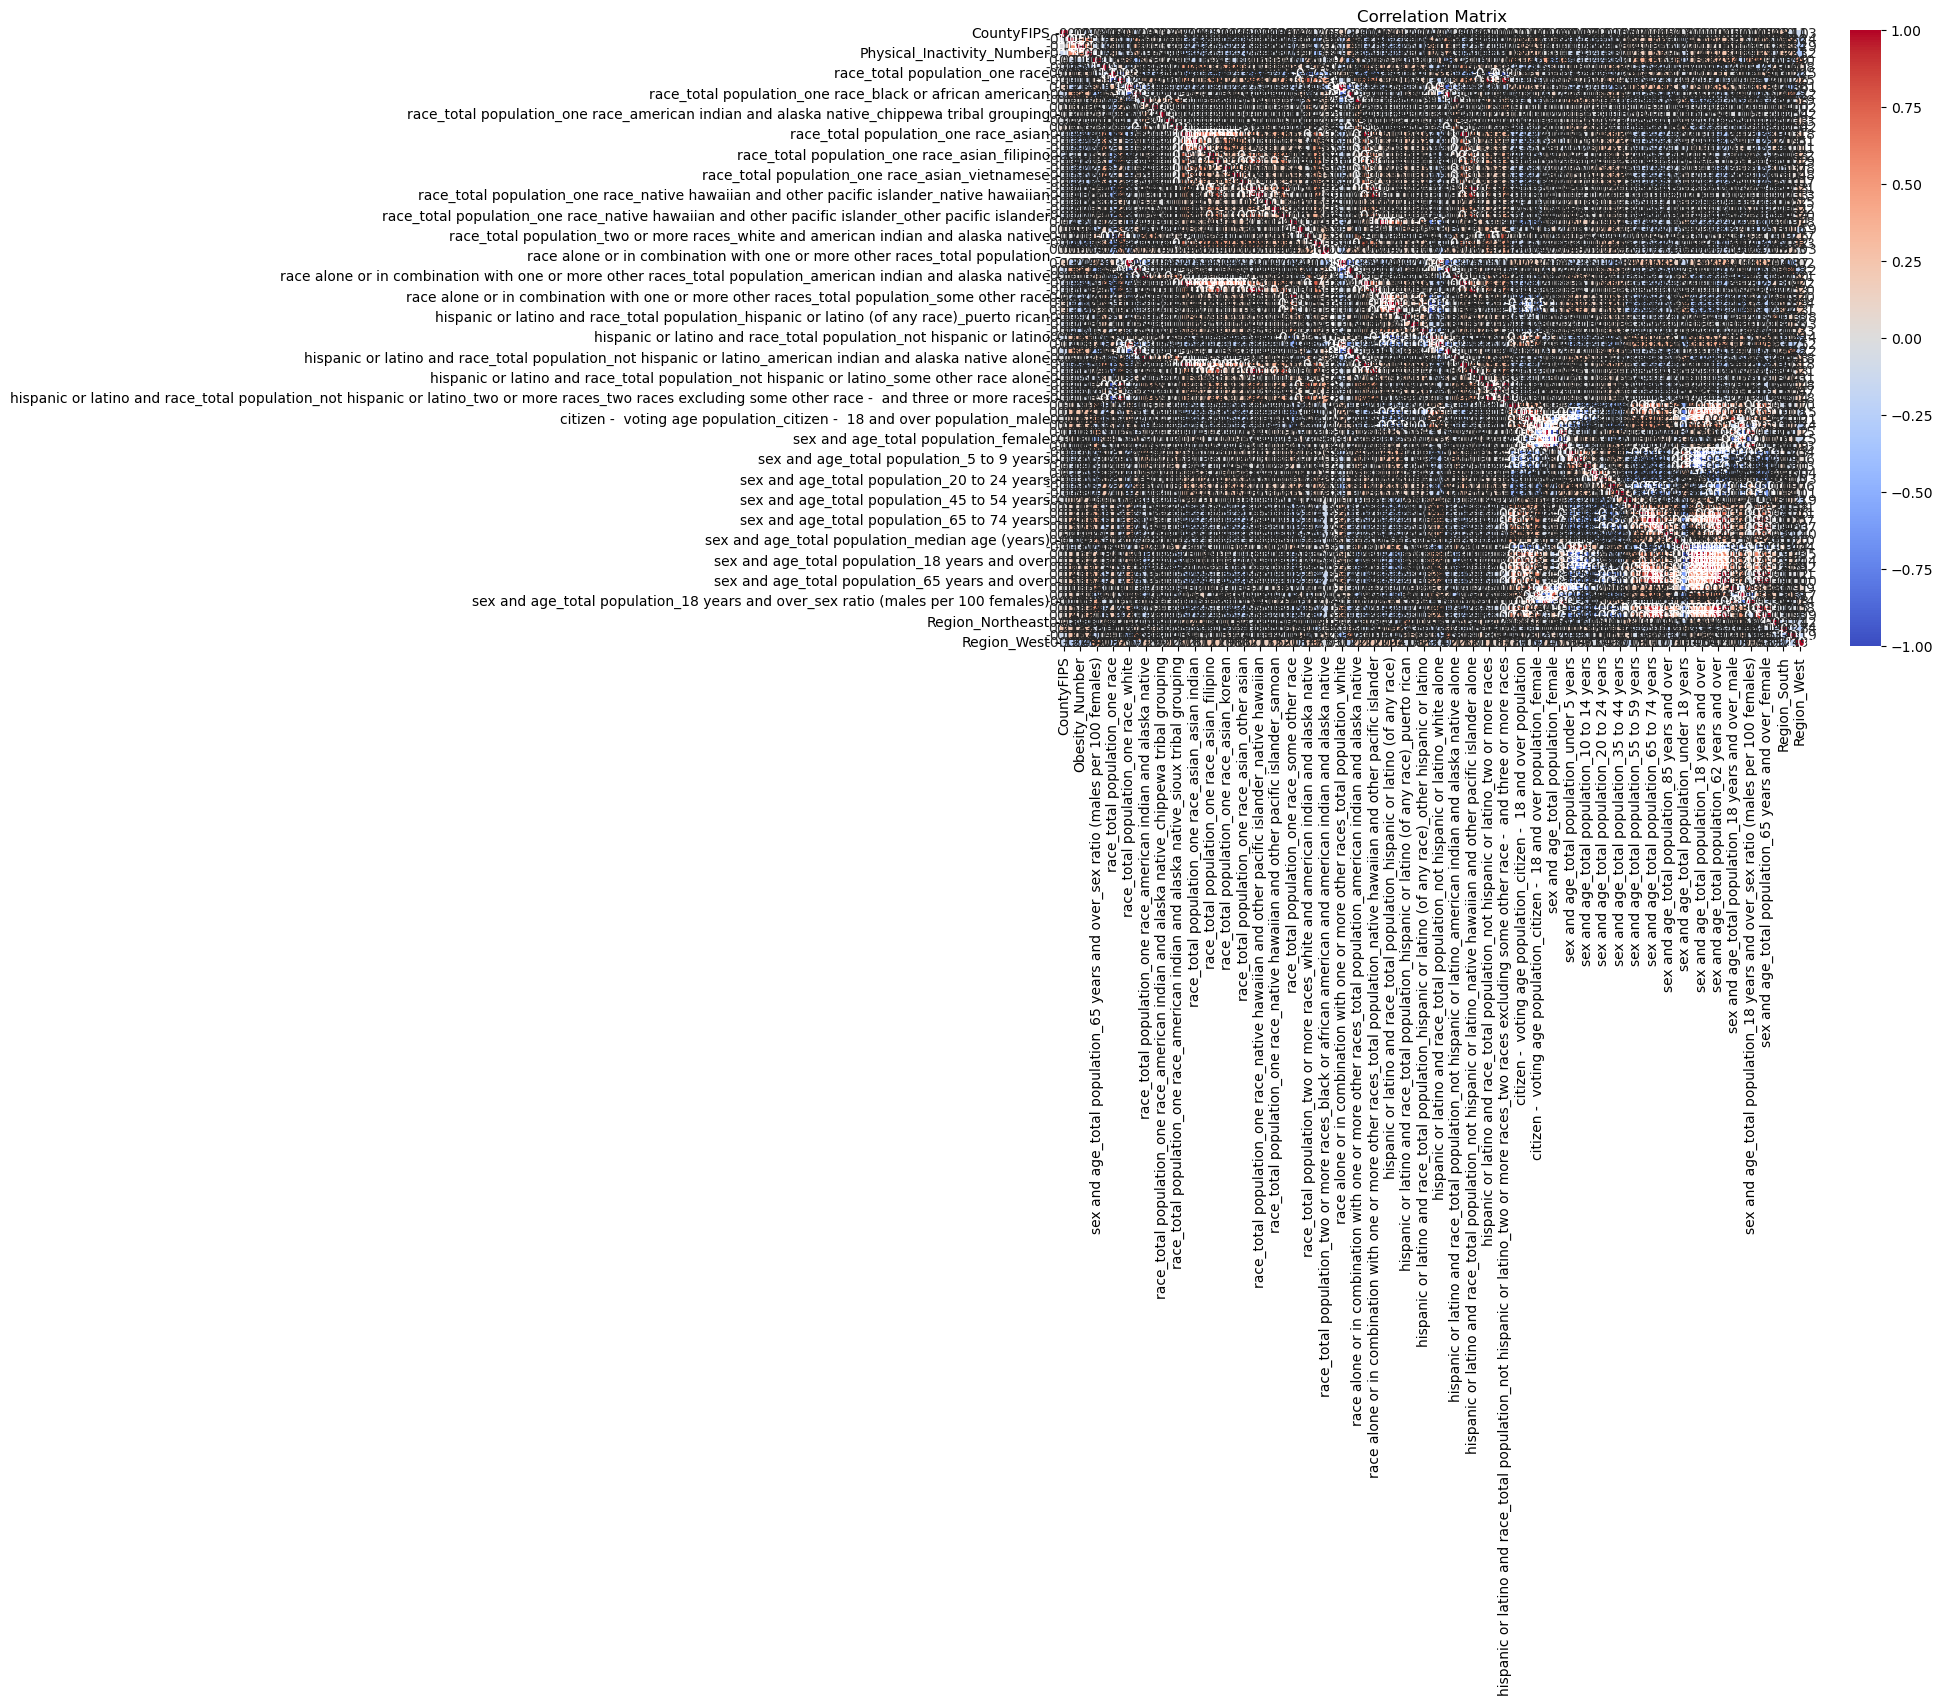

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

#Make a correlation matrix to see which features are correlated

correlation_matrix=diabetes_clean.corr()

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

#This is pretty ugly, let's just look at the numbers


In [24]:
diabetes_row = correlation_matrix.loc['Diabetes_Number']
print(diabetes_row)

CountyFIPS                                                                                                                                             -0.039051
Diabetes_Number                                                                                                                                         1.000000
Obesity_Number                                                                                                                                          0.549577
Physical_Inactivity_Number                                                                                                                              0.591118
sex and age_total population_65 years and over_sex ratio (males per 100 females)                                                                       -0.113471
race_total population                                                                                                                                  -0.154708
race_total population_one race    

In [25]:
#
# Feature selection
# I am dropping these based on what I see in the correlation matrix (i.e. the association between Diabetes_Number and these features
#Is there a cleaner way to do this?
#-----------
X = diabetes_clean.drop(columns=["race_total population_one race_american indian and alaska native_cherokee tribal grouping",                                                                
"race_total population_one race_american indian and alaska native_chippewa tribal grouping",                                                                
"race_total population_one race_american indian and alaska native_navajo tribal grouping",                                                                  
"race_total population_one race_american indian and alaska native_sioux tribal grouping",  
"race_total population_one race_asian_asian indian",                                                                                                        
"race_total population_one race_asian_chinese",                                                                                                             
"race_total population_one race_asian_filipino",                                                                                                            
"race_total population_one race_asian_japanese",                                                                                                            
"race_total population_one race_asian_korean",                                                                                                              
"race_total population_one race_asian_vietnamese",                                                                                                          
"race_total population_one race_asian_other asian",                                                                                                                                                                                       
"race_total population_one race_native hawaiian and other pacific islander_native hawaiian",                                                                
"race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro",                                                         
"race_total population_one race_native hawaiian and other pacific islander_samoan",                                                                         
"race_total population_one race_native hawaiian and other pacific islander_other pacific islander",  
"race_total population_two or more races_white and black or african american",                                                                              
"race_total population_two or more races_white and american indian and alaska native",                                                                      
"race_total population_two or more races_white and asian",                                                                                                  
"race_total population_two or more races_black or african american and american indian and alaska native",               
"hispanic or latino and race_total population_hispanic or latino (of any race)_mexican",                                                                    
"hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican",                                                               
"hispanic or latino and race_total population_hispanic or latino (of any race)_cuban",                                                                      
"hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino",                                                                             
"hispanic or latino and race_total population_not hispanic or latino_white alone",                                                                          
"hispanic or latino and race_total population_not hispanic or latino_black or african american alone",                                                      
"hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone",                                              
"hispanic or latino and race_total population_not hispanic or latino_asian alone",                                                                          
"hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone",                                     
"hispanic or latino and race_total population_not hispanic or latino_some other race alone",                                                                
"hispanic or latino and race_total population_not hispanic or latino_two or more races",                                                                    
"hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race",                                
"hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -  and three or more races",   
"sex and age_total population_sex ratio (males per 100 females)",                                                                                           
"sex and age_total population_under 5 years",                                                                                                               
"sex and age_total population_5 to 9 years",                                                                                                                
"sex and age_total population_10 to 14 years",                                                                                                              
"sex and age_total population_15 to 19 years",                                                                                                              
"sex and age_total population_20 to 24 years",                                                                                                              
"sex and age_total population_25 to 34 years",                                                                                                              
"sex and age_total population_35 to 44 years",                                                                                                              
"sex and age_total population_45 to 54 years",                                                                                                              
"sex and age_total population_55 to 59 years",                                                                                                              
"sex and age_total population_60 to 64 years",                                                                                                              
"sex and age_total population_65 to 74 years",                                                                                                              
"sex and age_total population_75 to 84 years",                                                                                                              
"sex and age_total population_85 years and over",                                                                                                                                                                                                                                                                                                                     
"sex and age_total population_16 years and over",                                                                                                           
"sex and age_total population_18 years and over",                                                                                                           
"sex and age_total population_21 years and over",                                                                                                           
"sex and age_total population_62 years and over",                                                                                                           
"sex and age_total population_65 years and over",                                                                                                                                                                                                            
"sex and age_total population_18 years and over_sex ratio (males per 100 females)","Diabetes_Number","race alone or in combination with one or more other races_total population", "citizen -  voting age population_citizen -  18 and over population_male","citizen -  voting age population_citizen -  18 and over population_female"], axis = 1)  



In [26]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size=0.8,      # specify proportional split for training
                                                    test_size=0.2)       # specify proportional split for test

In [27]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate =  train_test_split(X_train, 
                                                            y_train,
                                                            train_size=0.75, 
                                                            test_size=0.25)

In [28]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very low penalty (e.g., an alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  (OLS Linear Regression) 

**MODEL DESCRIPTION:**
**OLS Linear Regression:**
Linear regression is certainly not the most exciting method around, but it is still useful! If we are making policy recommendations about the implementation of a diabetes prevention plan, we need to understand the relationship between features in our dataset and Diabetes_Number. Linear regression assumes that there is an approximately linear relationship between  predictor variable and the outcome of interest. From our exploratory analyses, this may be reasonable to assume for several of our (potentially) key features. Our goal here is to estimate our coefficients to fit the data - we will do this using ordinary least squares (OLS) regression. Our hope is to minimize the residual sum of squares (RSS) by choosing our coefficients. As discussed here, OLS's (relative) simplicity has trade-offs. One of the most important is the assumption of linearity, but again, it seems reasonable to try OLS here at least initially. Another is a question of colinearity, which definitely could arise here. Variance is high with OLS but we get the added benefit of not worrying about bias in the same way that we do with Ridge, LASSO, etc. 

In [29]:
# load libraries 
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# use magic function
%matplotlib inline


# set style
sns.set_style("darkgrid")

In [30]:
#
# Model 1 training
# create a model
lin_reg = LinearRegression()

# fit the model
lin_model = lin_reg.fit(X_train, y_train)



In [31]:
# print model coefficients and intercept
print(lin_model.coef_)
print(lin_model.intercept_)

[-5.10876379e-08  8.30335713e-03  7.22203962e-03  4.81250818e-03
  3.53825922e-04  5.51329613e-04 -5.51329613e-04 -2.05626638e-02
  1.09432203e-02  1.97040052e-02  1.90843543e-02  2.08043091e-04
 -3.37410519e-03  3.85953840e-02  1.10905384e-02 -9.16078165e-03
 -1.89040587e-02  4.68559587e-03  7.11644338e-03  5.56012749e-04
 -5.56012749e-04 -2.08840433e-04  3.27347436e-03  1.47612827e-04
 -1.47612827e-04 -1.55618140e-03  1.24363382e-03 -1.35786219e-03
  2.37071033e-05 -8.13975289e-03  1.25166051e-02  3.95109742e-03
  9.89477458e-03  1.04995893e-02  3.81207730e-03]
0.08980393836111485


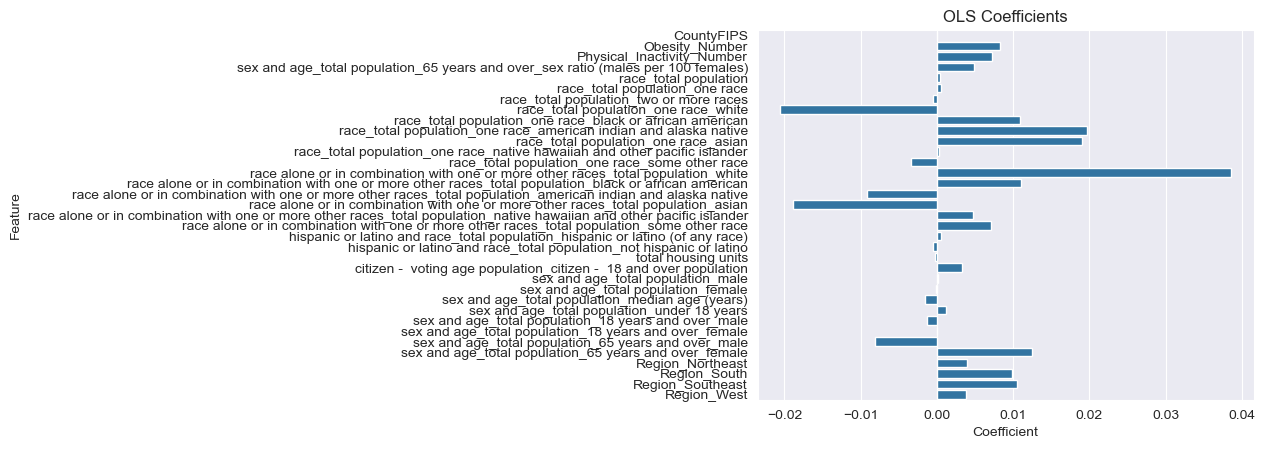

In [32]:
# create a dataframe with the coefficient and feature names for plotting
lin_reg_data = pd.DataFrame([lin_model.coef_, X.columns]).T # make a dataframe from the arrays
lin_reg_data.columns = ['Coefficient', 'Feature']           # add column names for clarity

# plot
ax = sns.barplot(x="Coefficient",                           # add x 
                 y="Feature",                               # add y
                 data=lin_reg_data)                         # specify data

ax.set_title("OLS Coefficients")                            # set title
plt.show()                                                  # show plot
#I imagine that some of these smaller coefficients might be due to the overlapping categorization of these features 
#(i.e. 'race_total population_one race' is not as meaningful as 'race_total population_one race_white')

In [33]:
#Get the OLS Coefficients to sort
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient':lin_model.coef_})

# Sort the DataFrame by Coefficient from smallest to largest
sorted_coef_df = coef_df.sort_values(by='Coefficient')

# Display sorted coefficients
print(sorted_coef_df)

                                              Feature   Coefficient
7                race_total population_one race_white -2.056266e-02
16  race alone or in combination with one or more ... -1.890406e-02
15  race alone or in combination with one or more ... -9.160782e-03
29  sex and age_total population_65 years and over... -8.139753e-03
12     race_total population_one race_some other race -3.374105e-03
25    sex and age_total population_median age (years) -1.556181e-03
27  sex and age_total population_18 years and over... -1.357862e-03
20  hispanic or latino and race_total population_n... -5.560127e-04
6             race_total population_two or more races -5.513296e-04
21                                total housing units -2.088404e-04
24                sex and age_total population_female -1.476128e-04
0                                          CountyFIPS -5.108764e-08
28  sex and age_total population_18 years and over...  2.370710e-05
23                  sex and age_total population

In [34]:
# see parameters for linear regression
lin_reg.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

#### Model 2:  Ridge Regression 

**MODEL DESCRIPTION:** 
**Ridge Regression:**
Ridge regression is different from OLS because of its usage of lambda, a tuning parameter. However, it is similar because it uses coefficients to fit the data with the goal of reducing RSS. When we increase lambda, the ridge regression fit is less flexible which leads to less variance but more bias. We, of course, think about this tradeoff. Ridge could be advantageous in an instance like this where we think there might be colinearity between features - as our penalty helps to stabilize the estimate (again, an advantage over OLS). One disadvantage of Ridge is that it includes all features in its models, so if we decided to ultimately use Ridge, we would have to manually exclude features not of interest. We will have to standardize after splitting to avoid data leakage.

In [35]:
#
# Model 2 training
#-----------
# make and fit a Ridge regression model
ridge_reg = Ridge()                                              # create the model
ridge_model = ridge_reg.fit(X_train, y_train)                    # fit the model

# create a dataframe with the coefficient and feature names for plotting
ridge_reg_data = pd.DataFrame([ridge_model.coef_, X.columns]).T  # create a dataframe from the estimates
ridge_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity



Text(0.5, 1.0, 'Ridge Coefficients')

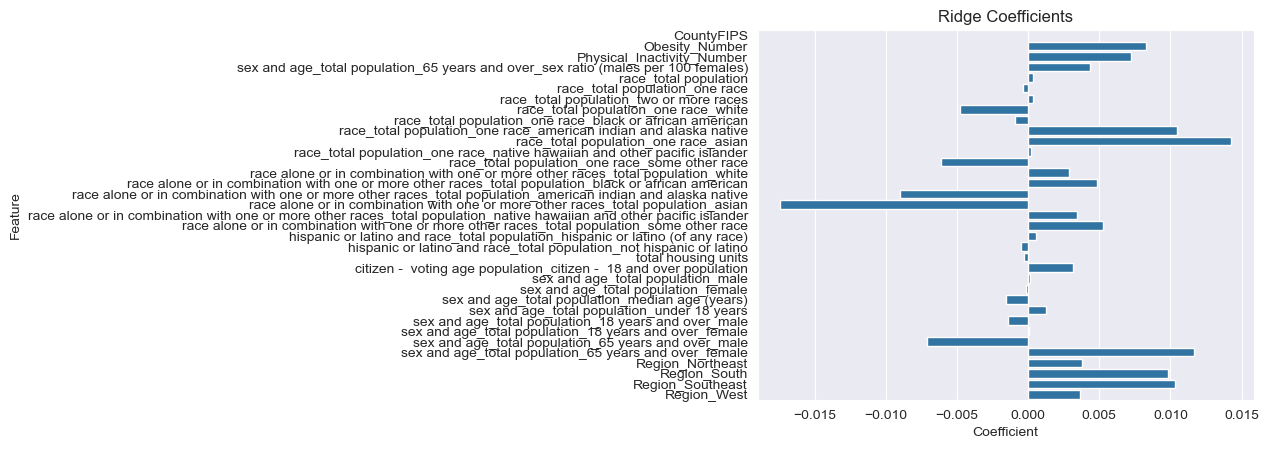

In [36]:
# set the figure parameters 
figure = plt.figure()                            # set the figure space
figure.subplots_adjust(wspace = .8, hspace=.5)   # adjust the space in between figures 



# specify barplot for Ridge
sns.barplot(x="Coefficient", 
            y="Feature", 
            data=ridge_reg_data).set_title("Ridge Coefficients")
#Hmm okay as we expected, Ridge doesn't take out features even if their coefficients are close to zero. If we choose ridge, we'll have to manually take out those ourselves

In [37]:
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient':ridge_model.coef_})

# Sort the DataFrame by Coefficient from smallest to largest
sorted_coef_df = coef_df.sort_values(by='Coefficient')

import pandas as pd

pd.set_option('display.max_rows', None)

# Display sorted coefficients
print(sorted_coef_df)

                                              Feature   Coefficient
16  race alone or in combination with one or more ... -1.741852e-02
15  race alone or in combination with one or more ... -8.974804e-03
29  sex and age_total population_65 years and over... -7.083806e-03
12     race_total population_one race_some other race -6.123024e-03
7                race_total population_one race_white -4.818486e-03
25    sex and age_total population_median age (years) -1.522228e-03
27  sex and age_total population_18 years and over... -1.377929e-03
8   race_total population_one race_black or africa... -9.271777e-04
20  hispanic or latino and race_total population_n... -5.209310e-04
5                      race_total population_one race -3.532739e-04
21                                total housing units -2.794536e-04
24                sex and age_total population_female -1.638451e-04
0                                          CountyFIPS -4.955662e-08
28  sex and age_total population_18 years and ov

#### Model 3:  LASSO Regression

**MODEL DESCRIPTION:** 
**LASSO:**
LASSO (Least Absolute Shrinkage and Selection Operator), like Ridge, also shrinks coefficient estimates, but the penalty is slightly different than Ridge. When we increase our lambda with LASSO, our penalty can shrink some of these coefficient estimates to be actually zero, which in effect helps us with feature selection. This of course introduces the bias-variance tradeoff, with increased bias and reduced variance. We will have to standardize after splitting to avoid data leakage. LASSO can be useful if we think there are different effects for different groups. 

In [38]:
# Model 3 training
#-----------
# create and fit the model
lasso_reg = Lasso(alpha=0.001,max_iter=15000)  # note the hypterparameter tuning will not converge with max_iter < 15000
lasso_model = lasso_reg.fit(X_train, 
                            y_train)

# create a dataframe with the coefficient and feature names for plotting
lasso_reg_data = pd.DataFrame([lasso_model.coef_, X.columns]).T  # create a dataframe from the estimates
lasso_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity


Text(0.5, 1.0, 'LASSO Coefficients')

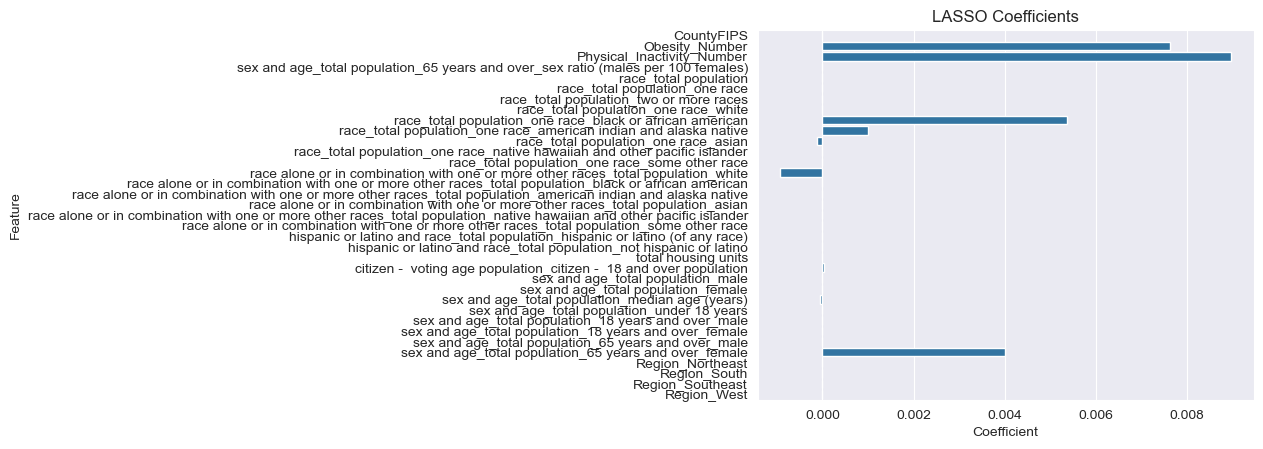

In [39]:
# specify barplot for LASSO 
sns.barplot(x="Coefficient", 
            y="Feature", 
            data=lasso_reg_data).set_title("LASSO Coefficients")


In [40]:
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient':lasso_model.coef_})

# Sort the DataFrame by Coefficient from smallest to largest
sorted_coef_df = coef_df.sort_values(by='Coefficient')

import pandas as pd

pd.set_option('display.max_rows', None)

# Display sorted coefficients
print(sorted_coef_df)

                                              Feature   Coefficient
13  race alone or in combination with one or more ... -9.256589e-04
10               race_total population_one race_asian -1.214095e-04
25    sex and age_total population_median age (years) -5.288355e-05
3   sex and age_total population_65 years and over...  0.000000e+00
7                race_total population_one race_white -0.000000e+00
12     race_total population_one race_some other race -0.000000e+00
5                      race_total population_one race  0.000000e+00
6             race_total population_two or more races -0.000000e+00
14  race alone or in combination with one or more ...  0.000000e+00
15  race alone or in combination with one or more ...  0.000000e+00
11  race_total population_one race_native hawaiian...  0.000000e+00
20  hispanic or latino and race_total population_n...  0.000000e+00
17  race alone or in combination with one or more ...  0.000000e+00
18  race alone or in combination with one or mor

In [41]:
lasso_reg.get_params()

{'alpha': 0.001,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 15000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

### Linear Regression


### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

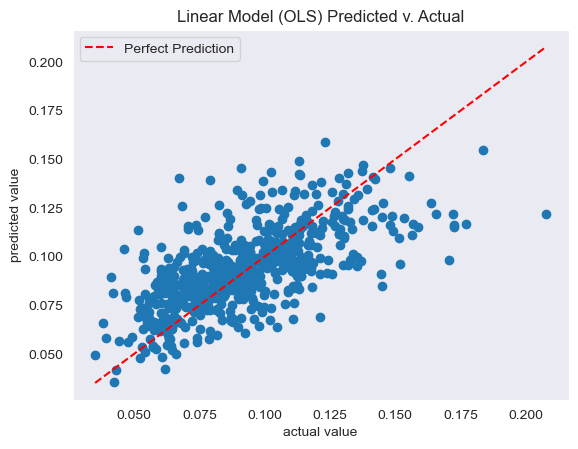

In [42]:
#
# Predict on validation data
#-----------
lin_pred = lin_model.predict(X_validate)

# plot the residuals on a scatter plot
plt.scatter(y_validate, lin_pred)                    # specify x and y of the scatter plot
plt.title('Linear Model (OLS) Predicted v. Actual')  # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label

#Make a line of fit
min_val = min(y_validate.min(), lin_pred.min())
max_val = max(y_validate.max(), lin_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')

# Optionally add a legend
plt.legend()

# Add a grid
plt.grid()

# Show the plot
plt.show()

In [43]:
# create function to calculate the root mean squared errror
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

In [44]:
# calculate root mean squared error for OLS
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rmse = np.sqrt(mean_squared_error(y_validate, lin_pred))
print("RMSE is:", rmse)
#calculate r2 value
r_squared = r2_score(y_validate, lin_pred)
print(f'R-squared: {r_squared:.4f}')

RMSE is: 0.020003683984829226
R-squared: 0.4092


In [45]:
#While our RMSE doesn't seem terribly high, meaning our predicted values didn't deviate from our actual values an egregious amount
#our R-squared value is pretty low. As we might've expected, OLS might not be our best-performing model.

### RIDGE


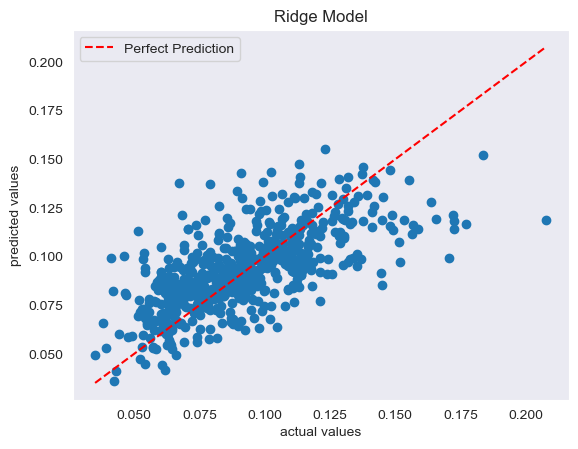

In [46]:
# use the model to make predictions
ridge_pred = ridge_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, ridge_pred)
plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')

#Make a line of fit
min_val = min(y_validate.min(), ridge_pred.min())
max_val = max(y_validate.max(), ridge_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')

# Optionally add a legend
plt.legend()

# Add a grid
plt.grid()

# Show the plot
plt.show()

In [47]:
# calculate the rmse for the Ridge model
rmse = np.sqrt(mean_squared_error(y_validate, ridge_pred))
print("RMSE is:", rmse)
#calculate r2 value
r_squared = r2_score(y_validate, ridge_pred)
print(f'R-squared: {r_squared:.4f}')

RMSE is: 0.019775293513494146
R-squared: 0.4226


In [48]:
#Okay our RMSE is a bit lower than OLS, which we can see visually, but our R-Squared is still pretty low. Let's hope that the LASSO can overcome this.

### LASSO 


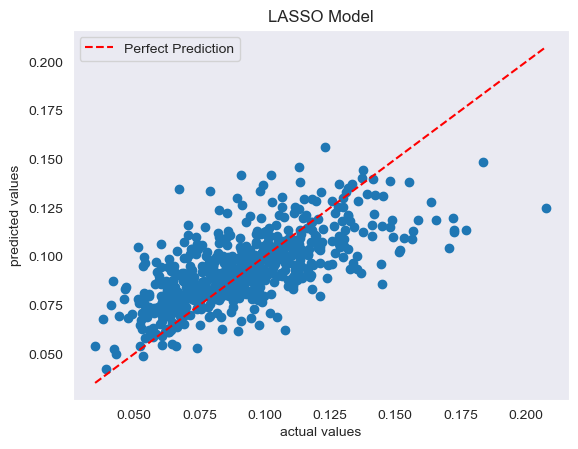

In [49]:
# use the model to make predictions
lasso_pred = lasso_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, lasso_pred)

# add title and labels
plt.title('LASSO Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
#Make a line of fit
min_val = min(y_validate.min(), lasso_pred.min())
max_val = max(y_validate.max(), lasso_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')

# Optionally add a legend
plt.legend()

# Add a grid
plt.grid()

# Show the plot
plt.show()

In [50]:
# calculate the rmse for the LASSO model
rmse = np.sqrt(mean_squared_error(y_validate, lasso_pred))
print("RMSE is:", rmse)
#calculate r2 value
r_squared = r2_score(y_validate, lasso_pred)
print(f'R-squared: {r_squared:.4f}')

RMSE is: 0.01945558371702626
R-squared: 0.4412


In [51]:
#Okay our RMSE is a bit lower than ridge and our R-squared is slightly higher, so let's go with LASSO

### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

In [52]:
#
# Feature selection
#After loooking at LASSO coefficients above, it seems like a good idea to select out some more features 

#-----------
X = diabetes_clean.drop(columns=["race_total population_one race_american indian and alaska native_cherokee tribal grouping",                                                                
"race_total population_one race_american indian and alaska native_chippewa tribal grouping",                                                                
"race_total population_one race_american indian and alaska native_navajo tribal grouping",                                                                  
"race_total population_one race_american indian and alaska native_sioux tribal grouping",  
"race_total population_one race_asian_asian indian",                                                                                                        
"race_total population_one race_asian_chinese",                                                                                                             
"race_total population_one race_asian_filipino",                                                                                                            
"race_total population_one race_asian_japanese",                                                                                                            
"race_total population_one race_asian_korean",                                                                                                              
"race_total population_one race_asian_vietnamese",                                                                                                          
"race_total population_one race_asian_other asian",                                                                                                         
"race_total population_one race_native hawaiian and other pacific islander",                                                                                
"race_total population_one race_native hawaiian and other pacific islander_native hawaiian",                                                                
"race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro",                                                         
"race_total population_one race_native hawaiian and other pacific islander_samoan",                                                                         
"race_total population_one race_native hawaiian and other pacific islander_other pacific islander",  
"race_total population_two or more races_white and black or african american",                                                                              
"race_total population_two or more races_white and american indian and alaska native",                                                                      
"race_total population_two or more races_white and asian",                                                                                                  
"race_total population_two or more races_black or african american and american indian and alaska native",               
"hispanic or latino and race_total population_hispanic or latino (of any race)_mexican",                                                                    
"hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican",                                                               
"hispanic or latino and race_total population_hispanic or latino (of any race)_cuban",                                                                      
"hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino",                                                                             
"hispanic or latino and race_total population_not hispanic or latino_white alone",                                                                          
"hispanic or latino and race_total population_not hispanic or latino_black or african american alone",                                                      
"hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone",                                              
"hispanic or latino and race_total population_not hispanic or latino_asian alone",                                                                          
"hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone",                                     
"hispanic or latino and race_total population_not hispanic or latino_some other race alone",                                                                
"hispanic or latino and race_total population_not hispanic or latino_two or more races",                                                                    
"hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race",                                
"hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -  and three or more races",   
"sex and age_total population_sex ratio (males per 100 females)",                                                                                           
"sex and age_total population_under 5 years",                                                                                                               
"sex and age_total population_5 to 9 years",                                                                                                                
"sex and age_total population_10 to 14 years",                                                                                                              
"sex and age_total population_15 to 19 years",                                                                                                              
"sex and age_total population_20 to 24 years",                                                                                                              
"sex and age_total population_25 to 34 years",                                                                                                              
"sex and age_total population_35 to 44 years",                                                                                                              
"sex and age_total population_45 to 54 years",                                                                                                              
"sex and age_total population_55 to 59 years",                                                                                                              
"sex and age_total population_60 to 64 years",                                                                                                              
"sex and age_total population_65 to 74 years",                                                                                                              
"sex and age_total population_75 to 84 years",                                                                                                              
"sex and age_total population_85 years and over",                                                                                                                                                                                                                                                                                                                     
"sex and age_total population_16 years and over",                                                                                                           
"sex and age_total population_18 years and over",                                                                                                           
"sex and age_total population_21 years and over",                                                                                                           
"sex and age_total population_62 years and over",                                                                                                           
"sex and age_total population_65 years and over",                                                                                                                                                                                                            
"sex and age_total population_18 years and over_sex ratio (males per 100 females)","Diabetes_Number","race alone or in combination with one or more other races_total population", "citizen -  voting age population_citizen -  18 and over population_male","citizen -  voting age population_citizen -  18 and over population_female", "race_total population",                                                                                                                                      
"race_total population_one race",                                                                                                                           
"race_total population_two or more races",                                                                                                      
 "CountyFIPS", 
"total housing units","race_total population_one race_black or african american",
                                 "sex and age_total population_65 years and over_sex ratio (males per 100 females)",
                                "sex and age_total population_18 years and over_male",
                                "sex and age_total population_18 years and over_female",], axis = 1)  



In [53]:
# Model 3 retraining
#-----------
# create and fit the model
lasso_reg = Lasso(alpha=0.001,max_iter=15000)  # note the hypterparameter tuning will not converge with max_iter < 15000
lasso_model = lasso_reg.fit(X_test, 
                            y_test)

# create a dataframe with the coefficient and feature names for plotting
lasso_reg_data = pd.DataFrame([lasso_model.coef_, X.columns]).T  # create a dataframe from the estimates
lasso_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity

Text(0.5, 1.0, 'LASSO Coefficients')

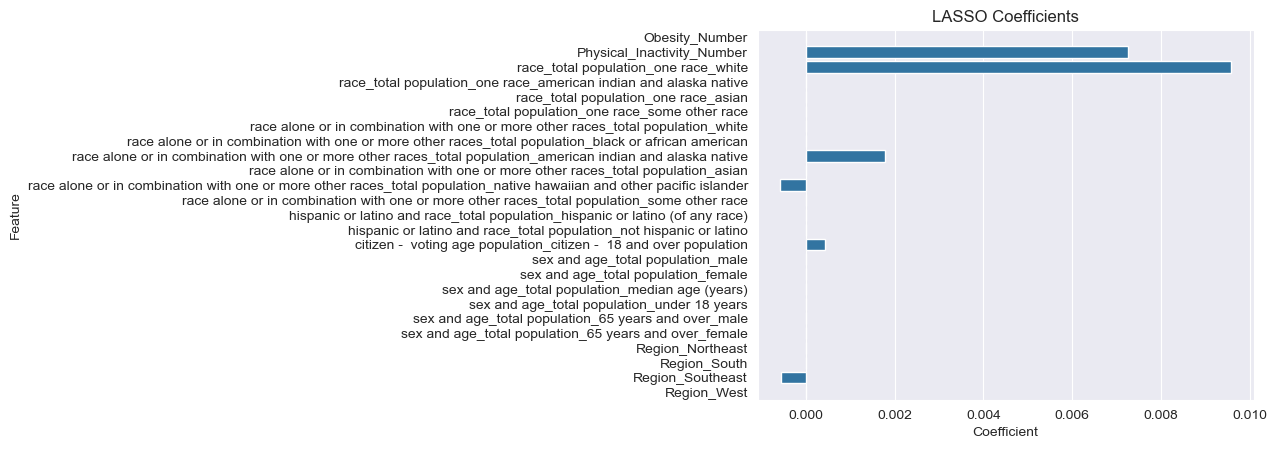

In [54]:
# specify barplot for LASSO 
sns.barplot(x="Coefficient", 
            y="Feature", 
            data=lasso_reg_data).set_title("LASSO Coefficients")

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)

# Initialize Lasso model
lasso_reg = Lasso(max_iter=15000)

# Specify the hyperparameters for grid search
param_grid = {
    'alpha': np.logspace(-4, 0, 10),  # Wide range of alpha values
    'fit_intercept': [True, False],
    'selection': ['cyclic', 'random']
}

# Execute the grid search
lasso_grid_reg = GridSearchCV(lasso_reg, param_grid, cv=5)  # 5-fold cross-validation

# Fit the grid search on the scaled training data
lasso_grid_reg.fit(X_train_scaled, y_train)

# Get the best estimator
lasso_model = lasso_grid_reg.best_estimator_

# Predictions
best_lasso_pred = lasso_model.predict(X_validate_scaled)

# Calculate metrics
r_squared = r2_score(y_validate, best_lasso_pred)
rmse_value = np.sqrt(mean_squared_error(y_validate, best_lasso_pred))

print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', r_squared)
print('Validation RMSE:', rmse_value)

Best CV R^2: 0.49573780810548856
Validation R^2: 0.451776238459372
Validation RMSE: 0.019270023054708197


### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)

# Initialize Lasso model
lasso_reg = Lasso(max_iter=15000)

# Specify the hyperparameters for grid search
param_grid = {
    'alpha': np.logspace(-4, 0, 10),  # Wide range of alpha values
    'fit_intercept': [True, False],
    'selection': ['cyclic', 'random']
}

# Execute the grid search
lasso_grid_reg = GridSearchCV(lasso_reg, param_grid, cv=5)  # 5-fold cross-validation

# Fit the grid search on the scaled training data
lasso_grid_reg.fit(X_train_scaled, y_train)

# Get the best estimator
lasso_model = lasso_grid_reg.best_estimator_

# Predictions
best_lasso_pred = lasso_model.predict(X_validate_scaled)

# Calculate metrics
r_squared = r2_score(y_validate, best_lasso_pred)
rmse_value = np.sqrt(mean_squared_error(y_validate, best_lasso_pred))

print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', r_squared)
print('Validation RMSE:', rmse_value)

Best CV R^2: 0.49576481566608666
Validation R^2: 0.4520486138844021
Validation RMSE: 0.019265235472356777


In [57]:
#Well, LASSO performed the best and it still wasn't great. Our Best Cross-Validation R-Squared value is still pretty low, as is our Validation R-Squared
#So a lot of our variation is not explained by the model
#However, our RMSE is lower!
#We improved our model, but not by much.

## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

**Question 1**
The bias-variance tradeoff refers to the issue (errors) we encounter in machine learning. When we are fitting our models, we must consider how our models both introduce and combat these two errors and how this relates to our ability to make accurate predictions outside of our dataset. Bias relates to the relationship between our predicted and actual outputs; with more bias, we risk underfitting our model, meaning our algorithm can miss important relationships between variables. On the other hand, when we overfit the model, or, when our model becomes too sensitive to the noise in our training data. Both underfitting and overfitting can lead to issues when we try and predict out-of-sample. This tension between bias-variance is fundamental in machine learning and is a major factor that we take into consideration when choosing and evaluating our models. 

2. Define overfitting, and why it matters for machine learning. How can we address it?

**YOUR ANSWER HERE**...
As indicated above, overfitting occurs when our model becomes too sensitive to the noise in our particular training data, limiting its ability to make accurate predictions on out-of-sample data. This is an issue because there are very few instances in which it would be ideal to make predictions just on one particular sample, most likely, we would like to be able to predict beyond our sample with accuracy. Overfitting is a common issue in machine learning modeling, and we make sure to evaluate and safeguard against it when we're creating our models. The train-test-validation split helps us in this regard. As the name suggests, we divide our data firstly into two subsets - a training and testing set. We train our model on the training data. Then we split the training data again (leaving aside the testing data) into validation sets. We use this validation set in order to make adjustments to our model before we use the 'test' dataset, as we want to leave that untouched until our model is ready. Then we test our algorithm finally using the test set that we set aside.

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

**YOUR ANSWER HERE**...
At the outset of our exploration of the data, there seemed to be myriad features that correlated to diabetes. Though, it is important to note that some of these features seemed more related to our outcome of interest than others, of course, and, additionally, it also seemed like there might be some colinearity between features. It is hard to give suggestions to this policymaker interested in implementing a diabetes prevention pilot program for several reasons. Firstly, we do not know *what* specific intervention the policymaker intends to implement. Knowing what the intervention is in advance might change the way we approach the data. 

With this aside, the goal of this analysis was to observe and model relationships between features in this dataset and our outcome of interest, Diabetes Rates. We firstly did some preliminary exploration of the data by examining relationships between different features. After seeing preliminary indications that physical inactivity, race, and obesity were both correlated with diabetes rates, we looked at variation in these features by-region and by-county, as this is the level of analysis that the policymaker is interested in. These preliminary analyses suggested that diabetes rates may be higher in the Southeast and South - we could speculate that this might be owing to any number of cultural, environmental, infrastructural, or economic reasons such as typical hobbies, weather, access to healthcare or public transportation, the existence of food deserts, etc. We then turned to our models to better study the relationships between features and our outcome, diabetes rates.

After finding and fitting our best possible model, we utilized a LASSO model to evaluate relevant features and their relationship to diabetes rates. In doing so, LASSO identified a small number of particularly important features - namely, physical inactivity, race (prevalence of white or indigenous people), and to a smaller extent, age. (See more below)

In [57]:
#Create a threshold
physical_inactivity_threshold = diabetes_counties['Physical_Inactivity_Number'].quantile(0.75)  # top 25%
white_threshold = diabetes_counties['race_total population_one race_white'].quantile(0.75)  # top 23
indigenous_threshold = diabetes_counties["race alone or in combination with one or more other races_total population_american indian and alaska native"].quantile(0.75)
print(f"Physical Inactivity Threshold: {physical_inactivity_threshold}")
print(f"white Threshold: {white_threshold}")
print(f"indigenous Threshold: {indigenous_threshold}")

Physical Inactivity Threshold: 0.2310405196180242
white Threshold: 0.9501927157025192
indigenous Threshold: 0.020071385271324023


In [58]:
# Create a list of thresholds
thresholds = {
    'Physical_Inactivity_Number': physical_inactivity_threshold,
    'race_total population_one race_white': white_threshold,
    "race alone or in combination with one or more other races_total population_american indian and alaska native":indigenous_threshold,
}

# Create an empty list to store the targeted counties
targeted_counties = []

# Iterate through each row in the DataFrame
for index, row in diabetes_counties.iterrows():
    if all(row[col] > thresholds[col] for col in thresholds):
        targeted_counties.append(row)

# Convert the list of targeted counties back to a DataFrame
targeted_counties_df = pd.DataFrame(targeted_counties)

# Display the targeted counties
#print(targeted_regions_df)
print("Shape of DataFrame:", targeted_counties_df.shape)

Shape of DataFrame: (20, 90)


In [59]:
diabetes.shape

(3112, 90)

In [60]:
county_names = targeted_counties_df['County']
print(county_names)

115          Boone County
177          Sharp County
179          Stone County
924      Greenwood County
941           Linn County
958        Osborne County
970           Rush County
1490        Benton County
1500        Carter County
1557        Oregon County
1587         Stone County
1593    Washington County
1664          Burt County
1713     Mcpherson County
2005        Foster County
2235       Sherman County
2575          Polk County
2639          Clay County
2859       Daggett County
3190      Washburn County
Name: County, dtype: object


**YOUR ANSWER 3 HERE Continued...**
Mathematically, we can (and have) calculated counties to target with our pilot program. The above list includes all the counties that meet the threshold of inclusion based on our most important features shown in our LASSO model. Although this is true, the implementation of any policy should be undergirded by a contextual understanding of each specific county. Just because our statistical model tells us that these are the counties we should target because they meet a statistical threshold, we still need to understand *why* this is the case. The answer to this question requires a contextual, and to some extent, historical understanding of these counties that the data simply cannot provide. Moreover, although LASSO has indicated that there are certain aforementioned important features in the data, we cannot be sure what unaccounted-for features might exist and we can wonder (especially given our far from perfect model performance) how those unobserved features might be influencing outcomes. 